<a href="https://colab.research.google.com/github/suprity04/Facegram/blob/main/Language_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth',200)

In [9]:
def read_text(deu):
 file = open(deu,mode='rt', encoding='utf-8')
 text=file.read()
 file.close()
 return text

In [10]:
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [11]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [12]:
deu_eng=deu_eng[:50000,:]


In [13]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [14]:
eng_1=[]
deu_1=[]
for i in deu_eng[:,0]:
  eng_1.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_1.append(len(i.split())) 


In [15]:
length_df = pd.DataFrame({'eng':eng_1, 'deu':deu_1})

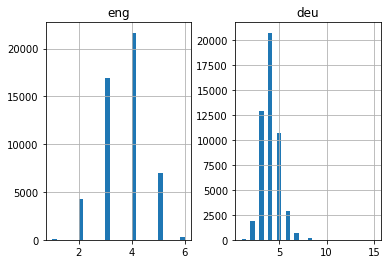

In [16]:
length_df.hist(bins=30)
plt.show()

In [17]:
def tokenization(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [18]:
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index)+1

eng_length=8
print('English Vocabulary Size: %d' % eng_vocab_size)


English Vocabulary Size: 6150


In [19]:
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index)+1

deu_length=8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)


Deutch Vocabulary Size: 10119


In [20]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [21]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [22]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [23]:
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [24]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [25]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [26]:
filename = 'model.h1.24_suprity'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
        epochs=5, batch_size=512,
        validation_split = 0.2, 
        callbacks=[checkpoint], verbose=1)

Epoch 1/5
63/63 [==============================] - 275s 4s/step - loss: 4.2958 - val_loss: 2.7911

Epoch 00001: val_loss improved from inf to 2.79107, saving model to model.h1.24_suprity


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


Epoch 2/5
63/63 [==============================] - 251s 4s/step - loss: 2.7160 - val_loss: 2.6546

Epoch 00002: val_loss improved from 2.79107 to 2.65464, saving model to model.h1.24_suprity


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


Epoch 3/5
63/63 [==============================] - 251s 4s/step - loss: 2.5596 - val_loss: 2.4800

Epoch 00003: val_loss improved from 2.65464 to 2.48000, saving model to model.h1.24_suprity


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


Epoch 4/5
63/63 [==============================] - 251s 4s/step - loss: 2.3536 - val_loss: 2.3687

Epoch 00004: val_loss improved from 2.48000 to 2.36869, saving model to model.h1.24_suprity


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


Epoch 5/5
63/63 [==============================] - 250s 4s/step - loss: 2.1998 - val_loss: 2.2506

Epoch 00005: val_loss improved from 2.36869 to 2.25059, saving model to model.h1.24_suprity


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


INFO:tensorflow:Assets written to: model.h1.24_suprity/assets


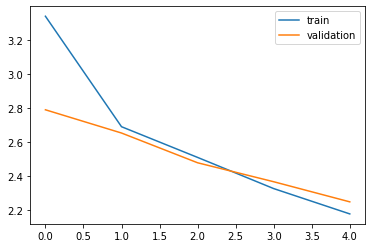

In [27]:
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [28]:
model=load_model('model.h1.24_suprity')
preds=model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [29]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index==n:
      return word
    return None  


In [30]:
preds_text= []
for i in preds:
    temp = []
    for j in range(len(i)):
        t=get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                 temp.append('t')
        else:
           if (t==None):
             temp.append('')
           else:
                temp.append('t')  

    preds_text.append(' '.join(temp))            
                        

In [31]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [32]:
pd.set_option('display.max_colwidth', 200)

In [33]:
pred_df.head(15)

,actual,predicted
0,What is the number?,
1,Try it on.,
2,We were wrong.,
3,That's untrue.,
4,Don't touch anything.,
5,Tom is calling back.,t
6,I think Tom is awake.,t
7,What are you having?,
8,I like that flag.,
9,You have a good job.,


In [34]:
pred_df.tail(15)

,actual,predicted
9985,I saw you looking.,t t
9986,Tom was so busy.,t
9987,Where could he be?,
9988,My friend was shot.,
9989,"Come on, trust me.",
9990,Life is too short.,
9991,Everybody saw it.,t
9992,Try harder.,
9993,He will be punished.,
9994,I speak Swedish.,
